In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [11]:
class Linear:
    def __init__(self, input_dim, output_dim):
        # THIS IS VERY VERY IMPORTANT
        # Any other initialization kept failing for me
        self.weights = np.random.randn(input_dim, output_dim) * np.sqrt(2. / input_dim)
        self.biases = np.zeros((1, output_dim))
        self.input = None

    def forward(self, x):
        self.input = x
        return x @ self.weights + self.biases

    def backward(self, grad_out, learning_rate):
        grad_in = grad_out @ self.weights.T

        grad_weights = self.input.T @ grad_out
        grad_biases = np.sum(grad_out, axis=0, keepdims=True)
        self.weights -= learning_rate * grad_weights
        self.biases -= learning_rate * grad_biases

        return grad_in

In [12]:
class Activation:
    def forward(self, x):
        raise NotImplementedError

    def backward(self, grad_output, learning_rate=None):
        raise NotImplementedError

class ReLU(Activation):
    def forward(self, x):
        self.output = x
        return np.maximum(0, x)

    def backward(self, grad_output, learning_rate=None):
        return grad_output * (self.output > 0)

class Tanh(Activation):
    def forward(self, x):
        self.output = np.tanh(x)
        return self.output

    def backward(self, grad_output, learning_rate=None):
        return grad_output * (1 - self.output ** 2)

class Sigmoid(Activation):
    def forward(self, x):
        self.output = 1 / (1 + np.exp(-x))
        return self.output

    def backward(self, grad_output, learning_rate=None):
        return grad_output * self.output * (1 - self.output)


In [13]:
class MLP:
    def __init__(self, layer_sizes, activation=ReLU):
        self.layers = []
        for i in range(len(layer_sizes) - 1):
            self.layers.append(Linear(layer_sizes[i], layer_sizes[i+1]))
            if i < len(layer_sizes) - 2:
                self.layers.append(activation())

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, grad_output, learning_rate):
        for layer in reversed(self.layers):
            grad_output = layer.backward(grad_output, learning_rate)

In [14]:
def generate_data(f, num_samples, noise_variance, xmax=5, xmin=-5):
    x_values = np.random.uniform(xmin, xmax, (num_samples, 1))
    y_values = f(x_values)
    noise = np.random.randn(*y_values.shape) * noise_variance
    y_data = y_values + noise
    return x_values, y_data

In [15]:
def mse_loss(y_data, y_predicted):
    return np.mean((y_data - y_predicted) ** 2)

def mse_loss_gradient(y_data, y_predicted):
    return 2 * (y_predicted - y_data) / y_data.shape[0]

In [30]:
def train(model, x_values, y_data, epochs=500, batch_size=64, learning_rate=0.005):
    losses = []
    n_samples = x_values.shape[0]
    for epoch in range(1, epochs + 1):
        permutation = np.random.permutation(n_samples)
        X_shuffled, y_shuffled = x_values[permutation], y_data[permutation]

        for i in range(0, n_samples, batch_size):
            x_batched = X_shuffled[i:i+batch_size]
            y_batched = y_shuffled[i:i+batch_size]

            y_predicted = model.forward(x_batched)
            loss = mse_loss(y_batched, y_predicted)
            grad = mse_loss_gradient(y_batched, y_predicted)
            model.backward(grad, learning_rate)

        if epoch % 50 == 0 or epoch == 1:
            print(f"Epoch {epoch:3d}, Loss: {loss:.5f}")

        if epoch % 5 == 0:
            losses.append((epoch, loss))

    return losses

Epoch   1, Loss: 1.11612
Epoch  50, Loss: 0.02426
Epoch 100, Loss: 0.02293
Epoch 150, Loss: 0.00766
Epoch 200, Loss: 0.01467
Epoch 250, Loss: 0.00881
Epoch 300, Loss: 0.00750
Epoch 350, Loss: 0.00278
Epoch 400, Loss: 0.00504
Epoch 450, Loss: 0.00356
Epoch 500, Loss: 0.00219
Epoch 550, Loss: 0.00154
Epoch 600, Loss: 0.00163
Epoch 650, Loss: 0.00097
Epoch 700, Loss: 0.00366
Epoch 750, Loss: 0.00557
Epoch 800, Loss: 0.00301
Epoch 850, Loss: 0.00146
Epoch 900, Loss: 0.00203
Epoch 950, Loss: 0.00369
Epoch 1000, Loss: 0.00498


Text(0.5, 1.0, 'Training Loss Over Epochs')

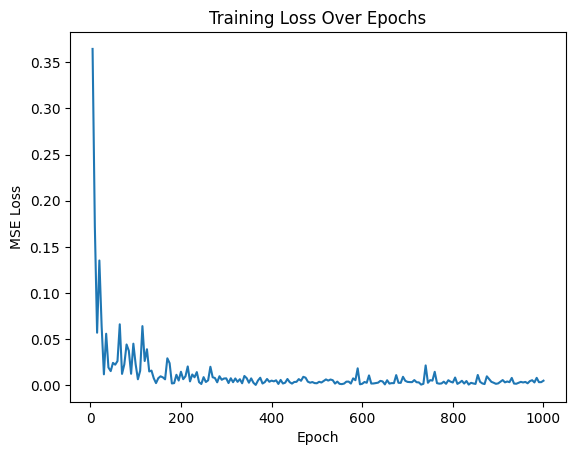

In [33]:
np.random.seed(0)

F = lambda x: np.exp(np.cos(x))
x, y = generate_data(F, num_samples=1000, noise_variance=0.05)

model = MLP([1, 32, 64, 64, 32, 1], activation=ReLU)
losses = train(model, x, y, epochs=1000, batch_size=32, learning_rate=0.01)
plt.plot(*zip(*losses), label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss Over Epochs")

In [34]:
x_validate = np.linspace(-5, 5, 100).reshape(-1, 1)
y_validate = model.forward(x_validate)
y_values = np.exp(np.cos(x_validate))

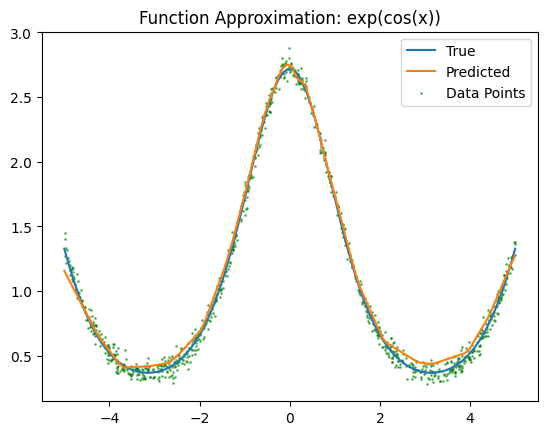

In [35]:
plt.plot(x_validate, y_values, label="True")
plt.plot(x_validate, y_validate, label="Predicted")
plt.scatter(x, y, color='green', s=1, label="Data Points", alpha=0.5)
plt.legend()
plt.title("Function Approximation: exp(cos(x))")
plt.show()
